In [209]:
import numpy as np
import time
import multiprocessing
import random 
from jax import random as jrandom
import jax.numpy as jnp
import jax
from scipy.optimize import fsolve
from jax import jit, partial

import matplotlib.pyplot as plt
from tqdm import tqdm 

%matplotlib inline
plt.rcParams['figure.figsize'] = [16,8]
plt.style.use('ggplot')
plt.rcParams['lines.markersize'] = 8


In [140]:
class Ackley:
    def __init__(self):
        pass
    
    def f(self, X):
        xs = X.T
        out_shape = xs[0].shape
        a = np.exp(-0.2 * np.sqrt(1. / len(xs) * np.square(np.linalg.norm(xs, axis=0))))
        b = - np.exp(1. / len(xs) * np.sum(np.cos(2 * np.pi * xs), axis=0))
        return np.array(-20 * a + b + 20 + np.exp(1)).reshape(out_shape)


    def f1(self, X, jrandom_key=None):
        """del H/del xi = -20 * -0.2 * (xi * 1/n) / sqrt(1/n sum_j xj^2) * a + 2 pi sin(2 pi xi)/n * b"""
        xs = X.T
        out_shape = xs.shape
        a = np.exp(-0.2 * np.sqrt(1. / len(xs) * np.square(np.linalg.norm(xs, axis=0))))
        b = -np.exp(1. / len(xs) * np.sum(np.cos(2 * np.pi * xs), axis=0))
        a_p = -0.2 * (xs * 1. / len(xs)) / np.sqrt(1. / len(xs) * np.square(np.linalg.norm(xs, axis=0)))
        b_p = -2 * np.pi * np.sin(2 * np.pi * xs) / len(xs)
        grad = np.nan_to_num(
            -20 * a_p * a + b_p * b).reshape(out_shape)  # only when norm(x) == 0 do we have nan and we know the grad is zero there
        grad = grad.T
        if jrandom_key is not None:
            return grad + 0.25 * jrandom.normal(jrandom_key, X.shape) * jnp.linalg.norm(grad, axis=1).reshape(-1, 1) / jnp.sqrt(X.shape[1])
        return grad

    def f2(self, X):
        h = 0.01
        dim = X.shape[1]
        nabla_f = self.f1(X)[0]
        X = X[0]
        X = h*jnp.eye(dim) + X
        H = jnp.zeros(shape=(dim, dim))
        num_samples = 1
        for _ in range(num_samples):
    #         print((F.f1(X, subkey) - nabla_f)/h)
            H = jax.ops.index_add(H, jax.ops.index[:, :], (self.f1(X) - nabla_f)/h)

        H = H / float(num_samples)
        return H.reshape(1, dim, dim)        
                

In [197]:
h_samples = 40


best_width_search(hessian_comp(true_H, gauss_f), G_upper_bound, G_lower_bound, h_samples, search_type="log")

res = []
x_upper_bound, x_lower_bound, x_samples = 100, -100, 100

for x in jnp.linspace(x_lower_bound, x_upper_bound, x_samples):
    x_0 =  x*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    res.append(A.f(x_0.reshape(1, -1)))

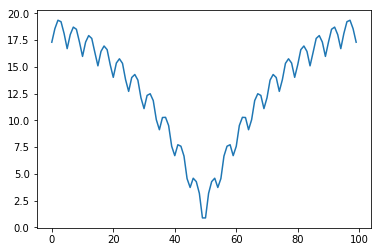

In [198]:
plt.plot(res)

In [213]:
A = Ackley()

# dim = 20
dim = 50
num_FD_samples = 10 * dim // 2
num_B_samples = 10 * dim

jrandom_key = jrandom.PRNGKey(0)

FD_upper_bound, FD_lower_bound = 0.2, 0.0001
B_upper_bound, B_lower_bound = 1000, 1
G_upper_bound, G_lower_bound = 1, 1e-6

h_samples = 20

FD_res = []
B_res = []
G_res = []

x_upper_bound, x_lower_bound, x_samples = 100, -100, 10

for x in tqdm(jnp.linspace(x_lower_bound, x_upper_bound, x_samples)):
#     print("X", x)
    x_0 =  x*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    true_H = A.f2(x_0.reshape(1, -1))[0]

    beta_f = lambda h: beta_2E1(A, x_0, h, num_B_samples, 2, jrandom_key)
    FD_f = lambda h: FD_2FD1(A, x_0, h, num_FD_samples, dim, jrandom_key)
    gauss_f = lambda h: gauss_2E1(A, x_0, h, num_B_samples, jrandom_key)

    FD_res.append(best_width_search(hessian_comp(true_H, FD_f), FD_upper_bound, FD_lower_bound, h_samples, search_type="log"))
    B_res.append(best_width_search(hessian_comp(true_H, beta_f), B_upper_bound, B_lower_bound, h_samples, search_type="log"))
    G_res.append(best_width_search(hessian_comp(true_H, gauss_f), G_upper_bound, G_lower_bound, h_samples, search_type="log"))
    
FD_res = jnp.array(FD_res)
B_res = jnp.array(B_res)
G_res = jnp.array(G_res)





  0%|          | 0/10 [00:00<?, ?it/s]



 10%|█         | 1/10 [00:36<05:27, 36.42s/it]



 20%|██        | 2/10 [01:15<04:57, 37.15s/it]



 30%|███       | 3/10 [01:54<04:24, 37.76s/it]



 40%|████      | 4/10 [02:33<03:48, 38.08s/it]



 50%|█████     | 5/10 [03:11<03:10, 38.15s/it]



 60%|██████    | 6/10 [03:49<02:32, 38.00s/it]



 70%|███████   | 7/10 [04:29<01:56, 38.79s/it]



 80%|████████  | 8/10 [05:08<01:17, 38.71s/it]



 90%|█████████ | 9/10 [05:46<00:38, 38.53s/it]



100%|██████████| 10/10 [06:25<00:00, 38.73s/it]

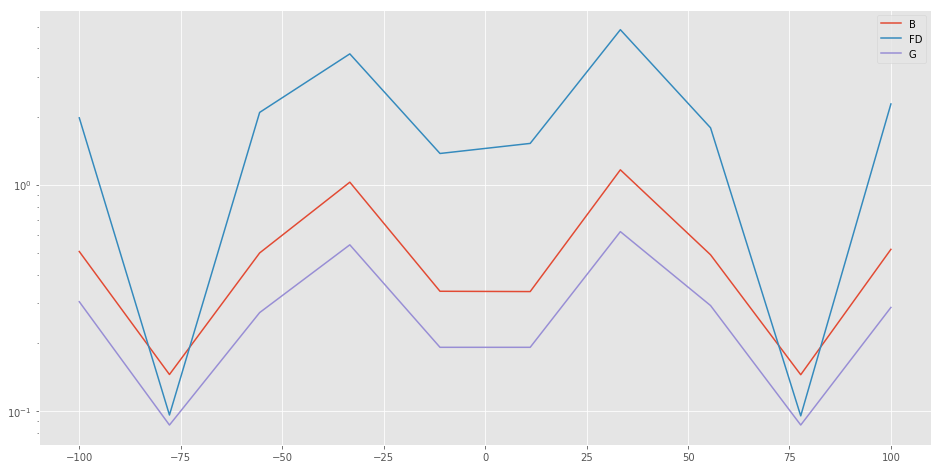

In [214]:
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), B_res[:, 1], label="B")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), FD_res[:, 1], label="FD")
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), G_res[:, 1], label="G")

plt.yscale("log")
plt.legend()
plt.show()

In [153]:
def jax_hit_run(x_0, F, dim, N, R, alpha, new_jrandom_key, chosen_basis_idx=None):
    new_jrandom_key, subkey = jrandom.split(new_jrandom_key)
    # sample gaussian and normalize 
    if chosen_basis_idx is None:
        dirs = jrandom.normal(subkey, shape=(N, dim)) 
    else:
        dirs = jrandom.normal(subkey, shape=(N, len(chosen_basis_idx)))
        temp_dirs = jnp.zeros((dim, N))
        temp_dirs = jax.ops.index_update(temp_dirs, chosen_basis_idx, dirs.T)
        dirs = temp_dirs.T

    dirs = dirs/jnp.linalg.norm(dirs, axis=1).reshape(-1, 1)

    new_jrandom_key, subkey = jrandom.split(new_jrandom_key)
    beta_p = (jrandom.beta(subkey, alpha, alpha, shape=(N, 1)) - 0.5) * 2 * R 

    res = []
    res += dirs * beta_p
    return x_0 + jnp.array(res)

def beta_2E1(F, x_0, alpha, N, R, jrandom_key, control_variate=True):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    sample_points = jax_hit_run(x_0, F, x_0.shape[0], N, R, alpha, subkey)  
    if control_variate: 
        ru = sample_points - jnp.mean(sample_points, axis=0)
    else:
        ru = sample_points - x_0
    jrandom_key, subkey = jrandom.split(jrandom_key)
    out_grads = F.f1(sample_points, subkey)
    g_ru = out_grads.T.dot(ru)/float(N)
    cov =  jnp.cov(sample_points.T).reshape(x_0.shape[0], x_0.shape[0]) # beta_covariance(x_0.shape[0], R, alpha) #
    return g_ru.dot(jnp.linalg.inv(cov))

def gauss_2E1(F, x_0, var, N, jrandom_key, control_variate=True):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    sample_points = x_0 + jnp.sqrt(var)*jrandom.normal(subkey, shape=(N, dim))  
    if control_variate: 
        ru = sample_points - jnp.mean(sample_points, axis=0)
    else:
        ru = sample_points - x_0
    jrandom_key, subkey = jrandom.split(jrandom_key)
    out_grads = F.f1(sample_points, subkey)
    g_ru = out_grads.T.dot(ru)/float(N)
    cov =  jnp.cov(sample_points.T).reshape(x_0.shape[0], x_0.shape[0]) # beta_covariance(x_0.shape[0], R, alpha) #
    return g_ru.dot(jnp.linalg.inv(cov))

In [154]:
def FD_2FD1(F, x_0, h, num_samples, dim, jrandom_key):
    hess = []
    jrandom_key, subkey = jrandom.split(jrandom_key)
    nabla_f = F.f1(x_0.reshape(1, -1), subkey)[0]
    X = h*jnp.eye(dim) + x_0
    H = jnp.zeros(shape=(dim, dim))

    for _ in range(num_samples):
        jrandom_key, subkey = jrandom.split(jrandom_key)
        H = jax.ops.index_add(H, jax.ops.index[:, :], (F.f1(X, subkey) - nabla_f)/h)

    H = H / float(num_samples)
    return H


In [155]:

def best_width_search(f, upper_bound, lower_bound, num_samples, search_type="log"):
    
    if search_type == "log":
        search_space = jnp.logspace(jnp.log(lower_bound)/jnp.log(10), jnp.log(upper_bound)/jnp.log(10), num_samples)
    else:
        search_space = jnp.linspace(lower_bound, upper_bound, num_samples)
        
    f_vals = [f(x) for x in search_space]
    curr_best = float("inf")
    curr_h = 0
    for i in range(len(search_space)):
        if curr_best > f_vals[i]:
            curr_best = f_vals[i]
            curr_h = search_space[i]
            
    return curr_h, curr_best
    
    
    
    
def hessian_comp(true_H, approx_H_func):
    def helper(h):
        approx_H = approx_H_func(h)
        return jnp.linalg.norm(true_H - approx_H)/jnp.linalg.norm(true_H)
    
    return helper

In [156]:
num_approx_samples = 2000



FD_upper_bound, FD_lower_bound = 0.2, 0.0001
B_upper_bound, B_lower_bound = 100, 1
G_upper_bound, G_lower_bound = 10, 0.0001
h_samples = 10

FD_R = 0.2

jrandom_key = jrandom.PRNGKey(0)

FD_res = []
B_res = []
G_res = []


for dim in range(50, 500, 50):
    print(dim)
    
    
    num_FD_samples = 20
    num_B_samples = 20 * dim
    
    x_0 =  jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    Q = jnp.eye(dim)
    F = Quadratic(Q, jnp.zeros(dim))
    true_H = F.f2(x_0.reshape(1, -1))[0]
    
    beta_f = lambda h: beta_2E1(F, x_0, h, num_B_samples, FD_R, jrandom_key)
    gauss_f = lambda h: gauss_2E1(F, x_0, h, num_B_samples, jrandom_key)
    FD_f = lambda h: FD_2FD1(F, x_0, h, num_FD_samples, dim, jrandom_key)
    
    curr_B_val = best_width_search(hessian_comp(true_H, beta_f), B_upper_bound, B_lower_bound, h_samples, search_type="log")[1]
    curr_FD_val = best_width_search(hessian_comp(true_H, FD_f), FD_upper_bound, FD_lower_bound, h_samples, search_type="log")[1]
    curr_G_val = best_width_search(hessian_comp(true_H, gauss_f), G_upper_bound, G_lower_bound, h_samples, search_type="log")[1]
    
    B_res.append(curr_B_val)
    FD_res.append(curr_FD_val)
    G_res.append(curr_G_val)
    
    
    

50
100
150
200
250
300
350
400
450


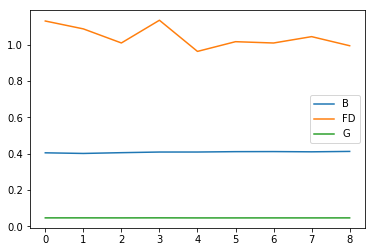

In [157]:
plt.plot(B_res, label="B")
plt.plot(FD_res, label="FD")
plt.plot(G_res, label="G")

# plt.yscale("log")
plt.legend()
plt.show()

In [151]:
class Quadratic:
    def __init__(self, Q, b):
        self.Q = Q
        self.Q_inv = jnp.linalg.inv(Q)
        self.b = b
        
    def f(self, X):
        Y = np.dot(self.Q, X.T)
        Y = jnp.diag(jnp.dot(X, Y)) + X.dot(self.b) # TODO fix. inefficient way to remove x_j^T Q x_i for i != j. 
        return Y
    
    def f1(self, X, jrandom_key=None):
        Y = 2*jnp.dot(self.Q, X.T)
        if jrandom_key is not None:
            return Y.T + self.b + 0.2 * jrandom.normal(jrandom_key, shape=Y.T.shape) * jnp.linalg.norm(Y.T, axis=1).reshape(-1, 1) / jnp.sqrt(X.shape[1]) 
        return Y.T + self.b

        
    def f2(self, X, jrandom_key=None):
        return 2 * np.array([list(self.Q)] * X.shape[0])

    def f2_inv(self, X):
        return 1/2. * np.array([list(self.Q_inv)] * X.shape[0])


In [253]:
class HappyCat:
    def __init__(self, alpha):
        self.alpha = alpha


        
    def f(self, X):
        dim = X.shape[1]
        X_norm = jnp.linalg.norm(X, axis=1)**2 
        return ((X_norm - dim)**2)**self.alpha + 1/float(dim) *(1/2. * X_norm + jnp.sum(X, axis=1)) + 1/2.
    
    def f1(self, X, jrandom_key=None):
        dim = X.shape[1]
        X_norm = jnp.linalg.norm(X, axis=1)**2 
        return (2*self.alpha)*jnp.abs(X_norm - dim)**(2*self.alpha - 1.)*2*X + 1/float(dim) * X + 1/float(dim)

        
#     def f2(self, X, jrandom_key=None):
#         return 2 * np.array([list(self.Q)] * X.shape[0])

#     def f2_inv(self, X):
#         return 1/2. * np.array([list(self.Q_inv)] * X.shape[0])
H = HappyCat(1)
H.f1(jnp.array([[1]]))

DeviceArray([[2.]], dtype=float32)

In [254]:
0 ** (2 * 1/8.)

0.0

In [257]:
dim = 1
res = []
resFD = []
res_f = []
x_upper_bound, x_lower_bound, x_samples = 2, -2, 100
H = HappyCat(2)
h = 0.1
for x in jnp.linspace(x_lower_bound, x_upper_bound, x_samples):
    x_0 =  x*jnp.ones(dim) / jnp.linalg.norm(jnp.ones(dim))
    res_f.append(H.f(x_0.reshape(1, -1)))
    res.append(H.f1(x_0.reshape(1, -1))[0])
    resFD.append((H.f((x_0 + h).reshape(1, -1)) - H.f(x_0.reshape(1, -1)))/h)

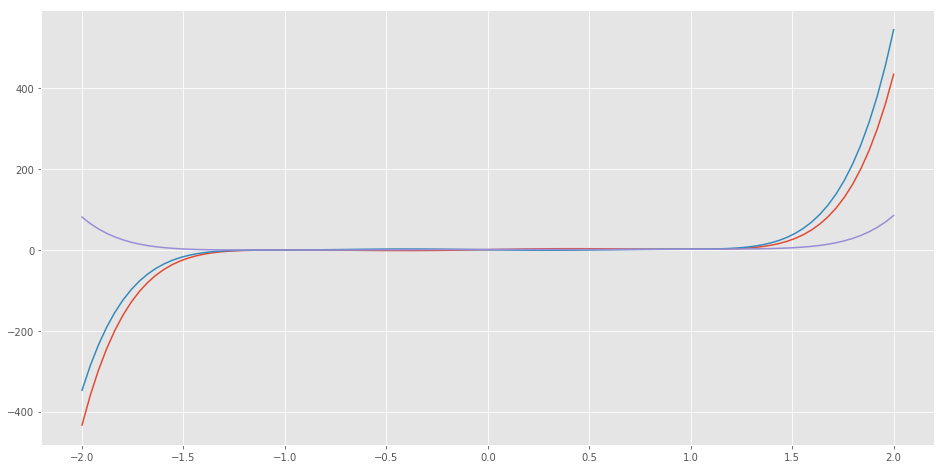

In [258]:
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), res)
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), resFD)
plt.plot(jnp.linspace(x_lower_bound, x_upper_bound, x_samples), res_f)
